## **BERT** 
>__[*original Turtorial Link*](https://www.tensorflow.org/text/tutorials/transformer)__

### Turtorial Summary
1. Downloading the Dataset
2. Text tokenization & detokenization
3. Setup of Input Pipeline 
4. Positional Encoding
5. Buidling Transformer Model from Scracth
6. Setting Hyperparameters 
7. Training and CheckPointing
8. Attention Plot
9. Exporting the saved model



    



In [63]:
import logging
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_text


In [64]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings

#### Downloading the datasets

In [65]:
## Downloading the Dataset
## useing Tensorflow datasets
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

In [66]:
##if got time look more for what does the take() method refers to 
for pt_examples, en_examples in train_examples.batch(3).take(1):
    for pt in pt_examples.numpy():

        print(pt.decode('utf-8'))
        print(len(pt.decode('utf-8')))

    print()

    for en in en_examples.numpy():
        print(en.decode('utf-8'))
        print(len(en.decode('utf-8')))


e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
95
mas e se estes fatores fossem ativos ?
38
mas eles não tinham a curiosidade de me testar .
48

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
111
but what if it were active ?
28
but they did n't test for curiosity .
37


2022-10-14 22:47:18.139060: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### tokenization & detokenization

In [67]:
### to train a NLP model first we need to tokenized them 
##Converting the text to sequence of token IDS 
## In simple words converting a sentence or words to list of unique tonek-IDS
## for tekenization, in this turtorial we will be using frozen model 


In [68]:
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

'./ted_hrlr_translate_pt_en_converter.zip'

In [69]:
##loading the model
tokenizers=tf.saved_model.load(model_name)

In [70]:
en_examples

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'and when you improve searchability , you actually take away the one advantage of print , which is serendipity .',
       b'but what if it were active ?',
       b"but they did n't test for curiosity ."], dtype=object)>

In [71]:
##Example of tokenization 
encoded_en_examples=tokenizers.en.tokenize(en_examples)


In [72]:
## encoded tokens of above en_examples
for row in encoded_en_examples.to_list():
    print(row)

[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]


*the shape of each input array is not same as the lenght of the sentence is not fixed*

In [73]:
### Decoding the encoded english examples 
round_trip = tokenizers.en.detokenize(encoded_en_examples)
for line in round_trip.numpy():
    print(line.decode('utf-8'))

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .


In [74]:
## How does the sequence of words are tokenized 
## using lookup() method


In [75]:
tokens = tokenizers.en.lookup(encoded_en_examples)
print(tokens)

<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability',
  b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage',
  b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip',
  b'##ity', b'.', b'[END]']                                                 ,
 [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?',
  b'[END]']                                                           ,
 [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for',
  b'curiosity', b'.', b'[END]']                                          ]>


In [76]:
lengths = []

for pt_examples, en_examples in train_examples.batch(1024):
    pt_tokens = tokenizers.en.tokenize(pt_examples)
    lengths.append(pt_tokens.row_lengths())
    #print(pt_tokens.row_lengths())
    en_tokens = tokenizers.en.tokenize(en_examples)
    lengths.append(en_tokens.row_lengths())
    print('.', end='', flush=True)

...................................................

In [77]:
lengths

[<tf.Tensor: shape=(1024,), dtype=int64, numpy=array([45, 21, 23, ..., 21, 47, 35])>,
 <tf.Tensor: shape=(1024,), dtype=int64, numpy=array([27,  9, 12, ...,  9, 23, 28])>,
 <tf.Tensor: shape=(1024,), dtype=int64, numpy=array([ 32,  22,  34, ...,  39, 101,  36])>,
 <tf.Tensor: shape=(1024,), dtype=int64, numpy=array([17, 12, 20, ..., 30, 56, 13])>,
 <tf.Tensor: shape=(1024,), dtype=int64, numpy=array([48, 37, 27, ..., 92, 21, 49])>,
 <tf.Tensor: shape=(1024,), dtype=int64, numpy=array([29, 18, 15, ..., 53, 13, 29])>,
 <tf.Tensor: shape=(1024,), dtype=int64, numpy=array([72, 38, 35, ..., 20, 54, 13])>,
 <tf.Tensor: shape=(1024,), dtype=int64, numpy=array([38, 18, 16, ..., 11, 26, 11])>,
 <tf.Tensor: shape=(1024,), dtype=int64, numpy=array([ 15,  24,  51, ...,  27,  40, 117])>,
 <tf.Tensor: shape=(1024,), dtype=int64, numpy=array([10, 16, 24, ..., 20, 24, 71])>,
 <tf.Tensor: shape=(1024,), dtype=int64, numpy=array([28, 44, 26, ..., 95, 34, 32])>,
 <tf.Tensor: shape=(1024,), dtype=int64, n

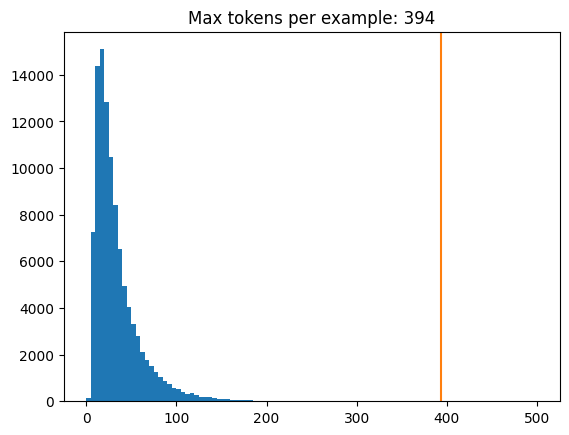

In [78]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Max tokens per example: {max_length}');

### Setting Input Pipeline

*Defining max_tokens*<br>
>max_tokens: Here max num of words for each batch size 


In [79]:
MAX_TOKENS=128

In [80]:
def tokenize_pairs(pt, en):
    #here pt and en are pt_examples[i] and en_examples[i]
    pt = tokenizers.pt.tokenize(pt)
    # Convert from ragged to dense, padding with zeros.
    pt = pt.to_tensor()

    en = tokenizers.en.tokenize(en)
    # Convert from ragged to dense, padding with zeros.
    en = en.to_tensor()
    return pt, en

In [81]:
## example
##pt_example, and en_example are from row number "Downloading Dataset 51 number"
pt,en=tokenize_pairs(pt_examples,en_examples)
print('pt\n {} \n\n en\n\n {}'.format(pt,en))

pt
 [[  2  88 120 ...   0   0   0]
 [  2 175 153 ...   0   0   0]
 [  2 101 105 ...   0   0   0]
 ...
 [  2 103 770 ...   0   0   0]
 [  2 133  14 ...   0   0   0]
 [  2  91 301 ...   0   0   0]] 

 en

 [[  2 110  13 ...   0   0   0]
 [  2  45 628 ...   0   0   0]
 [  2  87 140 ...   0   0   0]
 ...
 [  2  77  71 ...   0   0   0]
 [  2 110  13 ...   0   0   0]
 [  2  99 474 ...   0   0   0]]


In [82]:
print('pt.shape: {}\nen.shape: {}'.format(pt.shape,en.shape))


pt.shape: (585, 147)
en.shape: (585, 134)


*bool function to filter out inputs with num_tokens*
<br>tokenize pair are feeded to this function

In [83]:
def filter_max_tokens(pt, en):
    ##Here pt and en are tokenize value of pt_examples and en_examples
    num_tokens = tf.maximum(tf.shape(pt)[1],tf.shape(en)[1])
    return num_tokens < MAX_TOKENS

In [84]:
### Example of above function 
bool_tensor=filter_max_tokens(pt,en)
print(bool_tensor)
## meaning num_tokens is not less than the max tokens 

tf.Tensor(False, shape=(), dtype=bool)


**Example of tf.maximum**
<code>
    x = tf.constant([-5., -1., 0., 0.])
    y = tf.constant([-3.])
    c=tf.math.maximum(x, y)
    print(c)
</code>    
    

Here's a simple input pipeline that processes, shuffles and batches the data:

In [85]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [86]:
def make_batches(ds):
    return (
      ds
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)## Define above
      .filter(filter_max_tokens) #Define above
      .prefetch(tf.data.AUTOTUNE))


train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

### Positional Encoding 
>Similar to Embedding done in tf.keras.layers.Embedding() <br>
>>look into *An Attention is all we need* paper

In [87]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [88]:

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

In [89]:
positional_encoding(20,36)

<tf.Tensor: shape=(1, 20, 36), dtype=float32, numpy=
array([[[ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
          1.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
          1.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
          1.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
          1.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
          1.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
          1.00000000e+00,  0.00000000e+00,  1.00000000e+00],
        [ 8.41470957e-01,  5.40302277e-01,  5.64216733e-01,
          8.25626731e-01,  3.51695180e-01,  9.36114550e-01,
          2.13780671e-01,  9.76881683e-01,  1.28796190e-01,
          9.91671085e-01,  7.73490295e-02,  9.

### Masking
>Mask all the pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. The mask indicates where pad value 0 is present: it outputs a 1 at those locations, and a 0 otherwise.

*Note: We don't need masking skeleton based Posed based Action Recognition.*

In [90]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

*Similar function in array*
<code>
    def create_padding_mask(seq):
        seq=np.where(seq!=0,0,1)
        return seq
</code>    

*Masking Example*

In [91]:

x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

### look ahead mask
>The look-ahead mask is used to mask the future tokens in a sequence. In other words, the mask indicates which entries should not be used.<br>This means that to predict the third token, only the first and second token will be used. Similarly to predict the fourth token, only the first, second and the third tokens will be used and so on.

In [92]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [93]:
x = tf.random.uniform((1, 3))

temp = create_look_ahead_mask(x.shape[1]) 
#Value with 1 are masked 
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

In [94]:
x.shape[1]

3

### Building Transfomrer from scratch
i. Multi-Headed Attention Layer <br>
1. Linear Layer <br>
2. Scaler Dot Product Attention <br>
3. Final Linear Layer<br> 

ii. Encoder <br>
iii. Decoder <br>
iv. Tranformer Model <br>


In [95]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead)
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
    ## shape is determined by simple matrix multiplication rule 

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    #dk is the square root dimension of keys
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights


In [96]:
## here d_model is feature dimension as well as dimension of the k
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads): ##(self,*,d_model=dimension of k,num_heads)
        
        ##  d_model refer to the dimension of the q,v,k
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model) ## Must Define dense layer separately for all because Dense() always expect same shape but q,v,k may have different shape
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
    def split_heads(self, x, batch_size):
    #     Split the last dimension into (num_heads, depth).
    #     Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)

         #because of this split the computational time is same 
         #even when the number of heads is increased
        
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # q.shape= (batch_size, seq_len, d_model) ;Change the last dimesnion to d_model
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model) 
        ## this must assume the d_model and feature length is same 

        return output, attention_weights

*Testing the Above MultiHeadedAttention()*

In [97]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((63,43,64))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([63, 43, 512]), TensorShape([63, 8, 43, 43]))

In [98]:
y.shape

TensorShape([63, 43, 64])

### Point wise feed forward network
>Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.

In [99]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

## Encoder
Each encoder layer consists of sublayers:
1. Multi-head Attention
2. Point wise feed forward networks

In [100]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):

        attn_output, _ = self.mha(x, x, x, mask)  # att_ouptput.shape=(batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        ##d_model must be equal to feature_dimension otherwise error in addition x + attn_output
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

In [120]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)


sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

In [173]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self,*, num_layers, d_model, num_heads, dff, input_vocab_size,
               rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        ## To embed to d_model
        ## test code in below cell
        self.pos_encoding = positional_encoding(MAX_TOKENS, self.d_model)#

        self.enc_layers = [
            EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, rate=rate)
            for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        ## x.shape=[batch_size,seq_len]

        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        ### We don't need this while using skeleton features
        ### However the shape of the x will be [batch_size,seq_len,num_features]
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        
        x += self.pos_encoding[:, :seq_len, :] #Slices out the shape not in after embedding

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)

In [175]:
#try the below code to understand more about embedding and positional embedding

<code> #Python
emb=tf.keras.layers.Embedding(8500, 512)
pos=positional_encoding(MAX_TOKENS,512)
print('Pos_emb.shape: ',pos.shape)
Pos_emb.shape:  (1, 128, 512)
</code>    

<code> #Python
x=tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200) #input
x=emb(x)
print('After Embedding: x.shape ',x.shape)
</code>

<code> #Python
x *= tf.math.sqrt(tf.cast(512, tf.float32))
print('x.shape: ',x.shape)
</code>

<code> #Python
pos=pos[:,:62,:] # 62 =tf.shape(x)[1] 
print('Pos_emb.shape: ',pos.shape)
</code>

<code>
print(x.shape)=TensorShape([64, 62, 512])
</code>    

In [123]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, input_vocab_size=8500)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


In [124]:
emb=tf.keras.layers.Embedding(8500, 512)
pos=positional_encoding(MAX_TOKENS,512)
print('Pos_emb.shape: ',pos.shape)

Pos_emb.shape:  (1, 128, 512)


## Decoder layer
Each decoder layer consists of sublayers: <br>
1. Masked multi-head attention (with look ahead mask and padding mask) 
2. *** Multi-head attention (with padding mask). V (value) and K (key) receive the encoder output as inputs. Q (query) receives the output from the masked multi-head attention sublayer.  ***
3. Point wise feed forward networks.
<br> <br>
Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is LayerNorm(x + Sublayer(x)). The normalization is done on the d_model (last) axis.

>As Q receives the output from decoder's first attention block, and K receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output.<b> In other words, the decoder predicts the next token by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.</b>

In [125]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.mha2 = MultiHeadAttention(d_model=d_model, num_heads=num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,
               look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask) ## v,k,q order  
        # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  ## v and k are from encoder 
        # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [168]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output,
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

In [127]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self,*, num_layers, d_model, num_heads, dff, target_vocab_size,
                   rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(MAX_TOKENS, d_model)

        self.dec_layers = [
            DecoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, rate=rate)
            for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,
               look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)

            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

### Creating a Transformer Model


In [128]:
class Transformer(tf.keras.Model):
    def __init__(self,*, num_layers, d_model, num_heads, dff, input_vocab_size,
                   target_vocab_size, rate=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                               num_heads=num_heads, dff=dff,
                               input_vocab_size=input_vocab_size, rate=rate)

        self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                               num_heads=num_heads, dff=dff,
                               target_vocab_size=target_vocab_size, rate=rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inputs, training):
        # Keras models prefer if you pass all your inputs in the first argument
        inp, tar = inputs

        padding_mask, look_ahead_mask = self.create_masks(inp, tar)

        enc_output = self.encoder(inp, training, padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

    def create_masks(self, inp, tar):
        # Encoder padding mask (Used in the 2nd attention block in the decoder too.)
        padding_mask = create_padding_mask(inp)

        # Used in the 1st attention block in the decoder.
        # It is used to pad and mask future tokens in the input received by
        # the decoder.
        look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
        dec_target_padding_mask = create_padding_mask(tar)
        look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

        return padding_mask, look_ahead_mask

### Creating a sample Transformer model 

In [178]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048,
    input_vocab_size=8500, target_vocab_size=8000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer([temp_input, temp_target], training=False)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)


TensorShape([64, 36, 8000])

In [180]:
print('\tSummary of the model: \n')
print(sample_transformer.summary())

	Summary of the model: 

Model: "transformer_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_15 (Encoder)        multiple                  10656768  
                                                                 
 decoder_9 (Decoder)         multiple                  12504064  
                                                                 
 dense_683 (Dense)           multiple                  4104000   
                                                                 
Total params: 27,264,832
Trainable params: 27,264,832
Non-trainable params: 0
_________________________________________________________________
None


### Setting the HyperParameters


In [181]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

### Test the Transformer

### The main link has been updated. To find the previous turtorial on from tensorflow follow below link
[previous_turtorial](https://github.com/tensorflow/text/blob/2.9/docs/tutorials/transformer.ipynb)

### Training

In [182]:
## This learning rate is according to the paper "Attention is all we need!"
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

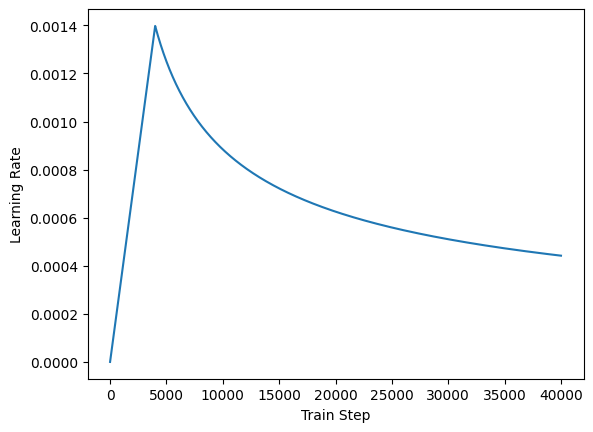

In [183]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

## Start from here next time

In [156]:


loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')



In [157]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)


In [158]:


train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')



In [159]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    rate=dropout_rate)

In [161]:
checkpoint_path = './checkpoints/train'

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')


In [162]:
EPOCHS = 20


In [163]:

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]


@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  with tf.GradientTape() as tape:
    predictions, _ = transformer([inp, tar_inp],
                                 training = True)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))


In [164]:


for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_batches):
    train_step(inp, tar)

    if batch % 50 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')



Epoch 1 Batch 0 Loss 8.8958 Accuracy 0.0000
Epoch 1 Batch 50 Loss 8.8254 Accuracy 0.0026
Epoch 1 Batch 100 Loss 8.7114 Accuracy 0.0229
Epoch 1 Batch 150 Loss 8.5964 Accuracy 0.0314
Epoch 1 Batch 200 Loss 8.4578 Accuracy 0.0366
Epoch 1 Batch 250 Loss 8.2897 Accuracy 0.0397
Epoch 1 Batch 300 Loss 8.1001 Accuracy 0.0449
Epoch 1 Batch 350 Loss 7.9007 Accuracy 0.0526
Epoch 1 Batch 400 Loss 7.7109 Accuracy 0.0594
Epoch 1 Batch 450 Loss 7.5410 Accuracy 0.0667
Epoch 1 Batch 500 Loss 7.3958 Accuracy 0.0744
Epoch 1 Batch 550 Loss 7.2599 Accuracy 0.0829
Epoch 1 Batch 600 Loss 7.1314 Accuracy 0.0910
Epoch 1 Batch 650 Loss 7.0121 Accuracy 0.0985
Epoch 1 Loss 6.9097 Accuracy 0.1047
Time taken for 1 epoch: 91.03 secs

Epoch 2 Batch 0 Loss 5.4292 Accuracy 0.1960
Epoch 2 Batch 50 Loss 5.3838 Accuracy 0.1981
Epoch 2 Batch 100 Loss 5.3439 Accuracy 0.2016
Epoch 2 Batch 150 Loss 5.3115 Accuracy 0.2048
Epoch 2 Batch 200 Loss 5.2714 Accuracy 0.2089
Epoch 2 Batch 250 Loss 5.2436 Accuracy 0.2121
Epoch 2 Batch 

KeyboardInterrupt: 